In [4]:
from os import listdir
from os.path import isfile, join
import re
demographic_files = [f for f in listdir('BabyNames/') if isfile(join('BabyNames/', f)) and re.search('^yob\d', f)]
demographic_files.sort()

In [5]:
import pandas as pd
def read_file(file_name):
    year = re.search('yob(\d+).txt', file_name).group(1)
    df = pd.read_csv('BabyNames/{0}'.format(file_name), sep=',', header=None)
    df.columns = ['Name', 'Sex', 'Count']
    df['Year'] = year
    return df

read_data_frames = [read_file(f_name) for f_name in demographic_files]

# Выполнение пункта 1 задания "Сгруппируйте данные по полу и году и визуализируйте общую динамику рождаемости обоих полов"

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

start_index = 1
end_index = 130
interval = 10

n_groups = len(read_data_frames[start_index:end_index]) / interval

years = []
mens_amount = []
womens_amount = []

def year_interval_name(frames, start_index, end_index):
    start_year = frames[start_index].loc[0]['Year']
    end_year = frames[end_index].loc[0]['Year']
    return '{0} - {1}'.format(start_year, end_year)

for index in range(start_index, end_index, interval):
    start_frame_index = index
    end_frame_index = index + interval - 1
    interval_mens_amount = 0
    interval_womens_amount = 0
    for frame in read_data_frames[start_frame_index:end_frame_index]:
        interval_mens_amount += frame.loc[frame['Sex'] == 'M', ['Count']].sum()['Count']
        interval_womens_amount += frame.loc[frame['Sex'] == 'F', ['Count']].sum()['Count']

    years += [year_interval_name(read_data_frames, start_frame_index, end_frame_index)]
    mens_amount += [interval_mens_amount]
    womens_amount += [interval_womens_amount]

years_values = tuple(years)
womens_values = tuple(womens_amount)
mens_values = tuple(mens_amount)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.4

rects1 = ax.bar(index, mens_values, bar_width,
                alpha=opacity, color='b',
                label='Men')

rects2 = ax.bar(index + bar_width, womens_values, bar_width,
                alpha=opacity, color='r',
                label='Women')

ax.set_xlabel('Years')
ax.set_ylabel('Total amount')
ax.set_title('Total peoples born')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(years_values)
ax.legend()

fig.tight_layout()
plt.rcParams["figure.figsize"] = [30, 4.8]
plt.show()



<Figure size 640x480 with 1 Axes>

# Выполнение пункта 2 задания "Найдите самые популярные имена за всю историю"

Количество людей по годам сильно меняется. Следовательно нельзя просто сложить количества людей и получить ответ.
Кроме этого очевидно что надо брать те, что на вершине списка т.к. в дата фрейме данные уже отсортированы по частоте.
Предположительно необхоимо найти N (у нас N будет 500) наиболее часто встречающихся, в процентном соотношении для совего года. Посчитать статистику по всем годам. И вот тут уже сложить все проценты и отсортировать по суммарному значению.

In [20]:
def count_percentage_for_set(data_frame, gender, limit=500):
    filtered_by_gender = data_frame.loc[data_frame['Sex'] == gender]
    probe = filtered_by_gender[0:limit]
    total_count = filtered_by_gender.get(['Count']).sum()['Count']
    probe['Relative frequency'] = probe['Count'].map(lambda count: count / total_count)
    result = probe.get(['Name', 'Relative frequency'])
    return result

def count_gender_percentages(frames, gender):
    result = []
    for frame in frames:
        result += [count_percentage_for_set(frame, gender)]
    return result

def get_most_frequent(percentages_list, limit=150):
    total_data_frame = pd.concat(percentages_list).groupby(['Name']).sum()
    result = total_data_frame.sort_values(by='Relative frequency', ascending=False)[0:limit]
    return result

male_percentages = count_gender_percentages(read_data_frames, 'M')
female_percentages = count_gender_percentages(read_data_frames, 'F')

chart_size = 10
males_chart = get_most_frequent(male_percentages, chart_size)
females_chart = get_most_frequent(female_percentages, chart_size)



/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<class 'list'>


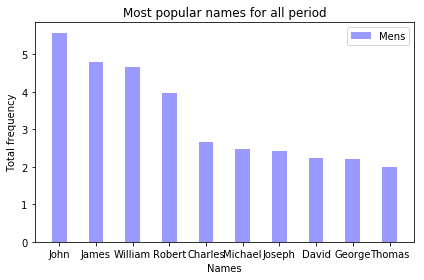

In [8]:

male_fig, male_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

male_values = tuple([values[0] for values in males_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
male_names = tuple(males_chart[0:chart_size].index.get_values())

most_popular_male_names = male_ax.bar(index, male_values, bar_width,
                                      alpha=opacity, color='b',
                                      label='Mens')

male_ax.set_xlabel('Names')
male_ax.set_ylabel('Total frequency')
male_ax.set_title('Most popular names for all period')
male_ax.set_xticks(index)
male_ax.set_xticklabels(male_names)
male_ax.legend()

male_fig.tight_layout()
plt.rcParams["figure.figsize"] = [6, 4.8]
plt.show()

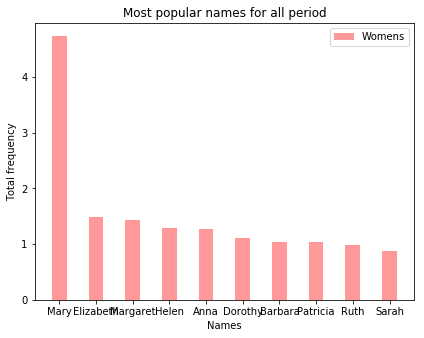

In [9]:
female_fig, female_ax = plt.subplots()

index = np.arange(chart_size)
bar_width = 0.4

opacity = 0.4

female_values = tuple([values[0] for values in females_chart[0:chart_size].get(['Relative frequency']).get_values().tolist()])
female_names = tuple(females_chart[0:chart_size].index.get_values())

most_popular_female_names = female_ax.bar(index, female_values, bar_width,
                                      alpha=opacity, color='r',
                                      label='Womens')

female_ax.set_xlabel('Names')
female_ax.set_ylabel('Total frequency')
female_ax.set_title('Most popular names for all period')
female_ax.set_xticks(index)
female_ax.set_xticklabels(female_names)
female_ax.legend()

female_fig.tight_layout()
plt.rcParams["figure.figsize"] = [6, 4.8]
plt.show()

# Выполнение пункта 3 задания. Нахождение наиболее популярных имён по промежуткам и построение динамики их частоты.

Алгоритмы подсчёта данных по номерам можно взять из пункта 2. Для построения динамики неоходимо будет использовать другой тип графиков.Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за все время

In [123]:
start_frame_index = 1
end_frame_index = 130
interval = 13

n_groups = len(read_data_frames[start_index:end_index]) / interval

years = []
mens_amount = []
womens_amount = []

def year_interval_name(frames, start_index, end_index):
    start_year = frames[start_index].loc[0]['Year']
    end_year = frames[end_index].loc[0]['Year']
    return '{0} - {1}'.format(start_year, end_year)

def most_frequent_names(all_frames, start_index, end_index, interval, gender):
    most_frequent_for_intervals = []

    for index in range(start_index, end_index, interval):
        start = index
        end = index + interval - 1
        most_frequent_for_intervals += [get_most_frequent_name_for_interval(all_frames, start, end, gender)]
        
    return [frequency.index[0] for frequency in most_frequent_for_intervals]

def get_most_frequent_name_for_interval(all_frames, start_index, end_index, gender):
    sum_peoples = []

    for frame in all_frames[start_index:end_index]:
        sum_peoples += [count_percentage_for_set(frame, gender, 100)]

    return get_most_frequent(sum_peoples, 1)

years = []

for index in range(start_frame_index, end_frame_index, interval):
    start = index
    end = index + interval - 1
    years += [year_interval_name(read_data_frames, start, end)]

womans_most_frequent_names = most_frequent_names(read_data_frames, start_frame_index, end_frame_index, interval, 'F')
mans_most_frequent_names = most_frequent_names(read_data_frames, start_frame_index, end_frame_index, interval, 'M')


/home/carefreeslacker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [126]:
index = np.arange(len(years))

def calculate_name_frequency(frames, gender, name):
    total_frame = pd.concat(frames)
    total_frame = total_frame.loc[total_frame['Sex'] == gender].get(['Name', 'Count']).groupby('Name').sum()
    
    sum_frames = pd.concat(frames)
    gender_selected = sum_frames.loc[sum_frames['Sex'] == gender, ['Name', 'Count']]
    grouped = gender_selected.groupby('Name').sum()
    total_count = grouped.get('Count').sum()
    name_count = grouped.loc[grouped.index == name].get('Count').sum()
    return name_count / total_count
    
def name_frequency_by_intervals(all_frames, start_index, end_index, interval, gender, name):
    total_peoples_frame = []

    for index in range(start_index, end_index, interval):
        start = index
        end = index + interval - 1
        total_peoples_frame += [calculate_name_frequency(all_frames[start:end], gender, name)]

    return total_peoples_frame

def iterate_through_names(names_set, gender):
    names_frequencies = []

    for name in names_set:
        names_frequencies += [name_frequency_by_intervals(read_data_frames, start_frame_index, end_frame_index, interval, 'M', 'John')]

    return names_frequencies

mans_names_frequencies = iterate_through_names(mans_most_frequent_names, 'M')

womans_names_frequencies = iterate_through_names(womans_most_frequent_names, 'F')

print(mans_most_frequent_names)
print(womans_most_frequent_names)


['John', 'John', 'John', 'Robert', 'Robert', 'James', 'Michael', 'Michael', 'Michael', 'Jacob']
['Mary', 'Mary', 'Mary', 'Mary', 'Mary', 'Linda', 'Lisa', 'Jennifer', 'Jessica', 'Emily']


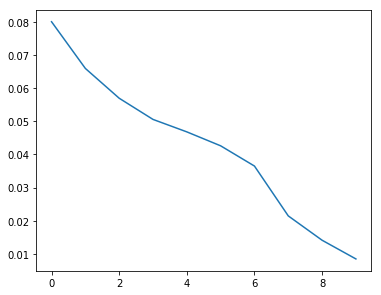

In [132]:
# print(pd.concat(read_data_frames[1:13]).get(['Name', 'Count']).groupby('Name').sum().get(['Count']))
# fig, ax = plt.subplots()
# mans_names_frequencies
# womans_names_frequencies
plt.plot(index, mans_names_frequencies[3])
# sum_frames = pd.concat(read_data_frames[1:14])

# gender_selected = sum_frames.loc[sum_frames['Sex'] == 'M', ['Name', 'Count']]
# grouped = gender_selected.groupby('Name').sum()
# total_count = grouped.get('Count').sum()
# name_count = gender_selected.loc[gender_selected['Name'] == 'John'].groupby('Name')
# print(grouped.loc[grouped.index == 'John'].get('Count').sum())
# print(total_count)
# print(name_count)

[0 1 2 3 4 5 6 7 8 9]
{'Robert', 'James', 'Jacob', 'Michael', 'John'}


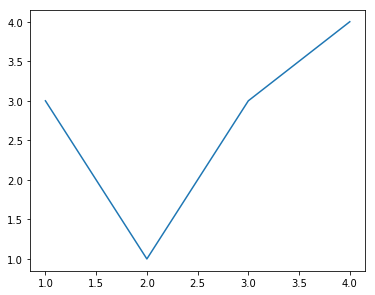

In [117]:
plt.plot([1,2,3,4], [3,1,3,4])
print(np.arange(10))
ar = ['John', 'John', 'John', 'Robert', 'Robert', 'James', 'Michael', 'Michael', 'Michael', 'Jacob']
print(set(ar))

In [52]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create a figure
plt.figure(1, clear=True)

# Creates a subplot
ax = fig.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Creates two subplots and unpacks the output array immediately
ax1, ax2 = fig.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Creates four polar axes, and accesses them through the
# returned array
axes = fig.subplots(2, 2, subplot_kw=dict(polar=True))
axes[0, 0].plot(x, y)
axes[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
fig.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
fig.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
fig.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
fig.subplots(2, 2, sharex=True, sharey=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f1eb90160>,
      dtype=object)

<Figure size 432x345.6 with 0 Axes>